# Теория 8. Наивный Байес и Классификация текстов

### Полезная литература

- [Naive Bayes and Text Classification](https://sebastianraschka.com/Articles/2014_naive_bayes_1.html)
- [ODS - классификация](https://habrahabr.ru/company/ods/blog/322534/)
- [Байесовский классификатор](http://www.machinelearning.ru/wiki/index.php?title=%D0%91%D0%B0%D0%B9%D0%B5%D1%81%D0%BE%D0%B2%D1%81%D0%BA%D0%B8%D0%B9_%D0%BA%D0%BB%D0%B0%D1%81%D1%81%D0%B8%D1%84%D0%B8%D0%BA%D0%B0%D1%82%D0%BE%D1%80)
- [Интересная статья про спам/не спам](https://habrahabr.ru/post/252265/)

Если вам понравилась задача распознавания текстов, то вот подборочка:

- [библиотека Gensim](https://radimrehurek.com/gensim/)
- [библиотека nltk](http://www.nltk.org/)
- [Лекция про word2vec 🔥](https://www.youtube.com/watch?v=oBb9aFmp0Hs)
- [Лекция Векторные представления слов и документов 🔥](https://www.youtube.com/watch?v=hiDBnEyoZS4)

### Классификация текстов

На примере [датасета SMS спама](https://archive.ics.uci.edu/ml/datasets/sms+spam+collection) научим наш классификатор отличать спам от обычного сообщения. Посмотрим как Наивный байесовский метод решает эту задачу и kNN. 

In [18]:
%matplotlib inline
from matplotlib import pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import classification_report, confusion_matrix

In [19]:
colab = False # если работаете на своём компьютере, поставьте False
if colab:
    from google.colab import drive
    drive.mount('/content/drive')

In [20]:
if colab:
    data = pd.read_csv('/content/drive/My Drive/data/SMSSpamCollection.tsv.gz', compression='gzip', sep='\t', header=None, names=['target', 'text'])
else:
    data = pd.read_csv("/home/rimsky/Projects/ml-solutions/ml_course/data/SMSSpamCollection.tsv.gz", compression='gzip', sep='\t', header=None, names=['target', 'text'])

data

,target,text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."
...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...
5568,ham,Will ü b going to esplanade fr home?
5569,ham,"Pity, * was in mood for that. So...any other s..."
5570,ham,The guy did some bitching but I acted like i'd...


In [21]:
# Посмотрим на типичных представителей датасета
print(data['target'][2],":", data['text'][2])
print()
print(data['target'][13],":", data['text'][13])

spam : Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's

ham : I've been searching for the right words to thank you for this breather. I promise i wont take your help for granted and will fulfil my promise. You have been wonderful and a blessing at all times.


/home/rimsky/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


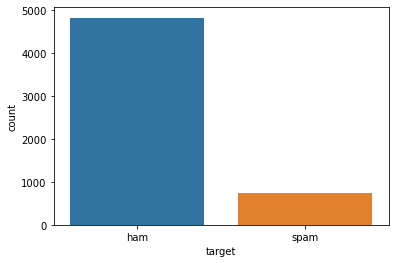

In [22]:
sns.countplot(data['target'])

In [23]:
data['len'] = data['text'].apply(len)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fe28b0672e0>,
      dtype=object)

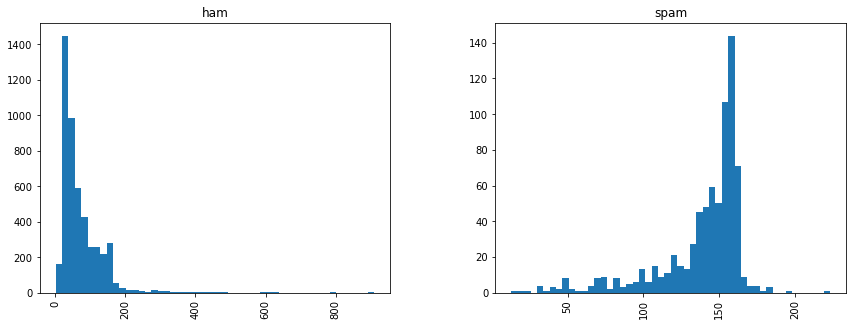

In [24]:
data.hist(column='len', by='target', bins=50,figsize=(14,5))

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fe28ad297f0>,
      dtype=object)

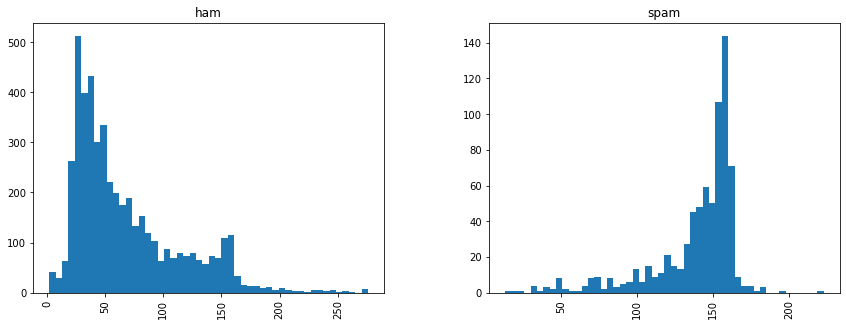

In [25]:
# какие-то странные длинные смс-ки. Посмотрим на распределение по-другому.
data[data['len'] < 280].hist(column='len', by='target', bins=50,figsize=(14,5))

### Генерация признаков текста 


![](https://cs5.pikabu.ru/images/previews_comm/2015-10_5/144549937818821131.jpg)

Алгоритмы машинного обучения работают с числовыми и категориальными данными. Если же у нас текст, его надо как-то привести к числовому виду. Для этого текст проходит предобработку, в которой можно выделить следующие стадии:

1. **Токенизация**: выделение из текста слов (токенов), например с помощью регулярных выражений.
2. **Отсечение стоп-слов**: слова, которые встречаются слишком часто, не несут никакой информации, только зашумляют данные, и их можно удалить. Это можно сделать с помощью словаря стоп-слов или просто отсекая слова, которые встречаются в обрабатываемых текстах чаще всего.
3. **Стемминг/лемматизация**: приведение слов к начальной форме, чтобы игрорировать различия во временах, числах, падежах и прочее. При стемминге используется алгоритм, отсекающий суффиксы (который, например, преобразует books в book, leaves в leav, а was в wa), при лемматизации - словарь, который позволит выполнить эту работу более точно (но за большее время, и, собственно, нужен словарь).
4. **Векторизация**: собственно то, ради чего всё затевалось $-$ преобразование набора слов в набор чисел. Двумя простейшими подходами являются bag-of-words, при котором просто считается, как часто встретилось каждое слово, и TF-IDF (term frequency - inverse document frequency), при котором больший вес даётся тем словам, которые встречаются в обрабатываемых текстах более редко.

Второй и третий этапы можно пропускать.

__источник: материалы курса [ODS](https://github.com/Yorko/mlcourse.ai)__


[Извлечение признаков из текста в Sklearn](http://scikit-learn.org/stable/modules/feature_extraction.html#text-feature-extraction)

[Сравнение качества работы мешка слов, TF-IDF и Word2Vec](http://ijaerd.com/papers/finished_papers/A_review_of_feature_extraction_methods_for_text_classification-IJAERDV05I0489982.pdf)

#### Count Vectorizer (Мешок слов)

[Доки по CountVectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html#sklearn.feature_extraction.text.CountVectorizer)

Можно начать с очень простой идеи. Давайте разобъем все предложения на слова. Составим словарь всех слов, которые будут встречаться во всех  наших текстах. И отметим, встречается ли это слово в нашем конкретном примере.  
Другими словами. Пусть в таблице в строках будут предложения, в столбцах - слова, а в ячейках число, которое показывает сколько раз это слово встречалось в этом предложении. Получается, что каждому объекту выборки будет сопоставлен вектор.



In [26]:
count_vectorizer = CountVectorizer()
texts = [
    "I've been searching for the right words to thank you for this breather.",
    "You have been wonderful and a blessing at all times",
    "I promise i wont take your help for granted and will fulfil my promise."
]
bow = count_vectorizer.fit_transform(texts)
print("Shape=", bow.shape)

Shape= (3, 28)


In [27]:
count_vectorizer.vocabulary_

{'ve': 21,
 'been': 3,
 'searching': 14,
 'for': 6,
 'the': 17,
 'right': 13,
 'words': 25,
 'to': 20,
 'thank': 16,
 'you': 26,
 'this': 18,
 'breather': 5,
 'have': 9,
 'wonderful': 23,
 'and': 1,
 'blessing': 4,
 'at': 2,
 'all': 0,
 'times': 19,
 'promise': 12,
 'wont': 24,
 'take': 15,
 'your': 27,
 'help': 10,
 'granted': 8,
 'will': 22,
 'fulfil': 7,
 'my': 11}

Теперь составим ту самую матрицу, где в столбцах слова, а в строках тексты.  
Как мы видим в первом и втором предложениях есть слово "been", а в третьем его нет.

In [28]:
bow.todense()

matrix([[0, 0, 0, 1, 0, 1, 2, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1,
         1, 0, 0, 0, 1, 1, 0],
        [1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
         0, 0, 1, 0, 0, 1, 0],
        [0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 2, 0, 0, 1, 0, 0, 0, 0, 0,
         0, 1, 0, 1, 0, 0, 1]])

Можно удалить "стоп слова" - слова, которые не несут особый смысл, но нужны для грамматики.

In [29]:
count_vectorizer = CountVectorizer(stop_words='english')
bow = count_vectorizer.fit_transform(texts)
print("Shape=", bow.shape)
count_vectorizer.vocabulary_

Shape= (3, 14)


{'ve': 10,
 'searching': 7,
 'right': 6,
 'words': 13,
 'thank': 8,
 'breather': 1,
 'wonderful': 11,
 'blessing': 0,
 'times': 9,
 'promise': 5,
 'wont': 12,
 'help': 4,
 'granted': 3,
 'fulfil': 2}

Дальше можно применять лемматизацию, стемминг и много чего другого. Но пока остановимся на этом и вернемся к спаму.

In [30]:
y = data['target']
X = data['text']

Можно ограничить словарь сверху и снизу.  
Выкинуть очень часто повторяющиеся слова и очень редкие. Что кстати логично, так как эти слова не несут никакого смысла.

```
max_df : float in range [0.0, 1.0] or int, default=1.0
    When building the vocabulary ignore terms that have a document
    frequency strictly higher than the given threshold (corpus-specific
    stop words).
    If float, the parameter represents a proportion of documents, integer
    absolute counts.
    This parameter is ignored if vocabulary is not None.

min_df : float in range [0.0, 1.0] or int, default=1
    When building the vocabulary ignore terms that have a document
    frequency strictly lower than the given threshold. This value is also
    called cut-off in the literature.
    If float, the parameter represents a proportion of documents, integer
    absolute counts.
    This parameter is ignored if vocabulary is not None.
```

In [31]:
vectorizer = CountVectorizer(stop_words='english', max_df=0.95, min_df=2)
X_vector = vectorizer.fit_transform(X)

In [32]:
vectorizer.get_stop_words()

frozenset({'a',
           'about',
           'above',
           'across',
           'after',
           'afterwards',
           'again',
           'against',
           'all',
           'almost',
           'alone',
           'along',
           'already',
           'also',
           'although',
           'always',
           'am',
           'among',
           'amongst',
           'amoungst',
           'amount',
           'an',
           'and',
           'another',
           'any',
           'anyhow',
           'anyone',
           'anything',
           'anyway',
           'anywhere',
           'are',
           'around',
           'as',
           'at',
           'back',
           'be',
           'became',
           'because',
           'become',
           'becomes',
           'becoming',
           'been',
           'before',
           'beforehand',
           'behind',
           'being',
           'below',
           'beside',
           'besides'

In [33]:
print("Количество слов в словаре: ", len(vectorizer.vocabulary_))
X_vector.shape

Количество слов в словаре:  3965


(5572, 3965)

Посмотрим на самые часто встречающиеся слова

In [34]:
# sorted(vectorizer.vocabulary_.items(), key=lambda x: x[1], reverse=True)[:50]

frequent_words = pd.DataFrame(columns=['Word', 'Count'])

frequent_words['Word'] = vectorizer.get_feature_names()
frequent_words['Count'] = X_vector.toarray().sum(axis=0)

frequent_words.iloc[np.argsort(frequent_words['Count'],)][:-50:-1]

,Word,Count
3686,ur,391
1973,just,376
1666,gt,318
2184,lt,316
2530,ok,293
1519,free,284
2124,ll,270
2017,know,262
2097,like,247
1632,good,247


Чтобы понять, хуже чего нельзя быть, возьмем глупый классификатор, который говорит, что все спам.

In [35]:
from sklearn.dummy import DummyClassifier

dm = DummyClassifier()
%time cross_val_score(dm, X_vector, y, cv=3).mean()

CPU times: user 48.8 ms, sys: 352 µs, total: 49.1 ms
Wall time: 53 ms


/home/rimsky/anaconda3/lib/python3.8/site-packages/sklearn/dummy.py:131: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  warnings.warn("The default value of strategy will change from "


0.7605887709669809

Далее возьмем известный нам K ближайших соседей.

In [36]:
from sklearn.neighbors import KNeighborsClassifier

%time cross_val_score(KNeighborsClassifier(n_neighbors=42, n_jobs=4), X_vector, y, cv=3).mean()

CPU times: user 1.46 s, sys: 482 ms, total: 1.94 s
Wall time: 1.37 s


0.8659368183575603

## А что скажет Байес?

![](https://i.pinimg.com/736x/22/7e/52/227e52ea4622a62344f1bc0a31111f43--bayes-theorem-game-theory.jpg)

$\LARGE P(A|B) = \frac{P(AB)}{P(B)} =  \frac{P(B \mid A)\, P(A)}{P(B)}$

Рассмотрим один из вариантов реализации классификатора

### Наивный байесовский классификатор
Очень хорошо про теорию написано [тут](http://bazhenov.me/blog/2012/06/11/naive-bayes.html). Попробуем реализовать по этой статье.

Модель классификатора строится на основе обучающей выборки. 
По ней необходимо найти следующюю статистику:  
1. Частоты классов в корпусе объектов (сколько объектов принадлежит каждому из классов)  (`classes_stats`)
2. Cуммарное число слов в документах каждого класса (`words_per_class`, далее см. $L_c$)
3. Частоты слов в пределах каждого класса (`word_freqs_per_class`, далее используется для расчета $W_{ic}$)
4. Размер словаря выборки (число признаков) - кол-во уникальных слов в выборке (`num_features`)

По сути, это метод `fit` классификатора.

На этапе предсказания необходимо воспользоваться следующей формулой:

$$
\begin{equation}
predicted\ class = \operatorname*{arg\max}_{c \in C} \left[\log{{D_c} \over {D}} + \sum_{i \in Q}{\log{{W_{ic} + 1} \over {|V| + L_c}}}\right]
\end{equation}
$$

Поясним некоторые переменные в этом выражении:  
$D_c$ - количество документов в обуч. выборке $\in$ классу $c$

$D$ - сколько всего было документов в обуч. выборке

$|V|$ - количество уникальных слов во сех документах обуч. выборки

$L_c$ - cуммарное число слов в документах класса $c$ обучающей выборки
 
$W_{ic}$ - сколько раз $i$ слово встретилось в объектах класса $c$ обучающей выборки

$Q$ - множество слов _классифицируемого_ документа




In [37]:
X_train, X_test, y_train, y_test = train_test_split(X_vector, y, random_state=42, test_size=0.5)

Общая сигнатура классификатора такова:  
```python
class NaiveBayes:
    def fit(self, x, y) -> None

    def predict(self, x) -> List[str]
```

Найдем для начала различные статистики, описанные в разделе и в самом материале по ссылке

Общее число документов в обучающей выборке (`doc_num`)

In [38]:
doc_num = X_train.shape[0]
doc_num

2786

Словарь, содержащий число объектов каждого класса (`classes_stats`)

In [39]:
classes_stats = y_train.value_counts().to_dict()
classes_stats

{'ham': 2409, 'spam': 377}

Число уникальных признаков (слов) в тренировочной выборке (`num_features`)

In [40]:
num_features = X_train.shape[1]
num_features

3965

Создадим словарь `indexes`, в котором ключом будет являться имя класса, а значением ключа - список строк матрицы X, принадлежащих конкретному классу

Обратите внимание на переменную `y` - это объект `Series` со сместившейся индексацией. Это индексацию необходимо исправить, воспользовавшись `Series.reset_index(drop=True)`

In [41]:
y = y_train.reset_index(drop=True)

indexes = {}

for clazz in classes_stats:
    indexes.update({clazz: y[y == clazz].index})

indexes

{'ham': Int64Index([   0,    1,    2,    4,    5,    7,    9,   10,   11,   12,
             ...
             2775, 2776, 2777, 2778, 2779, 2781, 2782, 2783, 2784, 2785],
            dtype='int64', length=2409),
 'spam': Int64Index([   3,    6,    8,   13,   22,   24,   30,   36,   41,   44,
             ...
             2726, 2729, 2733, 2745, 2750, 2751, 2758, 2760, 2764, 2780],
            dtype='int64', length=377)}

Используя найденные выше индексы, подсчитаем два важных параметра `words_per_class` и `word_freqs_per_class`.  
Обе этих переменных являются словарями, но первая из них отвечает за суммарное число слов, использованных в **каждом классе**, а вторая показывает, сколько раз конкретное слово встретилось в документах определенного класса.  Соответственно, формат переменной `words_per_class` - `{str: int}`, формат `word_freqs_per_class` - `{str: List}`.
Мы специально объеденили поиск двух разных статистик в одном блоке, чтобы избежать лишних циклов.

Чтобы найти в X строки, относящиеся к тому или иному классу, воспользуйтесь поиском по маске `indexes` для нужного класса.

Также помните, что X - это разреженная матрица, но из нее можно получить обычный массив через метод `toarray()`

In [42]:
x_arr = X_train.toarray()

words_per_class = {}
word_freqs_per_class = {}

for clazz in classes_stats:
    class_ids = indexes[clazz]
    
    curr_class_rows = x_arr[class_ids]
    words_per_class.update({clazz: np.sum(curr_class_rows, axis=0)})
    
    total_word_count = np.sum(words_per_class.get(clazz))
    word_freqs_per_class.update({clazz:words_per_class.get(clazz) / total_word_count})

words_per_class, word_freqs_per_class

({'ham': array([ 0,  0,  0, ..., 20,  0,  1]),
  'spam': array([ 5, 15,  0, ...,  0,  6,  1])},
 {'ham': array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         1.30301648e-03, 0.00000000e+00, 6.51508242e-05]),
  'spam': array([0.00091996, 0.00275989, 0.        , ..., 0.        , 0.00110396,
         0.00018399])})

Все вышенаписанные переменные образуют метод `fit` будущего классификатора. Теперь внесите этот код в метод `fit`, и не забудьте сделать найденный переменные полями класса.

In [43]:
class NaiveBayes:
    def __init__(self):
        pass

    def fit(self, x, y):
        self.classes_stats = y.value_counts().to_dict()

        self.doc_num = x.shape[0]

        self.num_features = x.shape[1]
        
        self.words_per_class = {}
        self.word_freqs_per_class = {}
        
        x_arr = X_train.toarray()

        for clazz in classes_stats:
            class_ids = indexes[clazz]
    
            curr_class_rows = x_arr[class_ids]
            words_per_class.update({clazz: np.sum(curr_class_rows, axis=0)})
    
            total_word_count = np.sum(words_per_class.get(clazz))
            word_freqs_per_class.update({clazz:words_per_class.get(clazz) / total_word_count})

Теперь реализуем метод `predict`. Если вы внимательно читали статью, то заметили, что в примере мы получили не чистые _вероятности_ классов, а всего лишь числовые оценки. Далее эти оценки можно перевести в вероятности при помощи софтмакса, но мы этого делать не будем.

Тогда промежуточный выход классификатора обозначим так:

`pred_per_class = [{класс: оценка}, ... , {класс: оценка}]`

Получая новую оценку для класса, мы сравниваем ее с уже имеющейся в массиве. Если она больше, то перезаписываем значение. Индекс словарика = индексу  строки в матрице Х./

Не забудьте о следующих вещах:
- `X_test` - это такая же разряженная матрица, нужно превратить ее в список
- переменная $ {D_c} \over {D} $ одинакова для одного класса.
- Чтобы подсчитать $W_{ic}$ воспользуйтесь `word_freqs_per_class`.
- Чтобы понять, какие элементы вам нужно брать в `word_freqs_per_class`, найдите индексы ненулевых элементов в классифицируемой строке - если эти элементы ненулевые, значит, там было какое-то слово (логично, не правда ли?)

Теперь просто выберите класс с наибольшей оценкой, и сформируйте список классов.

In [44]:
import math

def predict(x):
    pred_per_class = np.empty(x.shape[0], dtype=object)
    
    x = x.toarray()
    first_class = True

    
    for clazz in classes_stats.keys():
        Dc_D = np.log(classes_stats.get(clazz) / doc_num)
        
        denominator = num_features + np.sum(words_per_class.get(clazz))
        
        for rowID, row in enumerate(x):
            ids = np.nonzero(row)
            
            numerator = []
            for i in ids:
                numerator.append(word_freqs_per_class[clazz][i] + 1)
            
            numerator = np.array(numerator)
            
            log = np.log(numerator / denominator)
            sigma = np.sum(log)
            sigma += Dc_D
            
            if first_class:
                pred_per_class[rowID] = {clazz: sigma} 
            else:
                if list(pred_per_class[rowID].values())[0] < sigma: 
                    pred_per_class[rowID] = {clazz: sigma}
                    
        first_class = False
    return [list(x.keys())[0] for x in pred_per_class]

In [45]:
# len(predict(X_test)) == len(y_test)
predict(X_test)

['spam',
 'spam',
 'spam',
 'spam',
 'spam',
 'spam',
 'spam',
 'spam',
 'spam',
 'ham',
 'spam',
 'spam',
 'spam',
 'spam',
 'spam',
 'ham',
 'spam',
 'ham',
 'spam',
 'ham',
 'spam',
 'ham',
 'spam',
 'spam',
 'spam',
 'ham',
 'spam',
 'spam',
 'ham',
 'ham',
 'spam',
 'spam',
 'spam',
 'spam',
 'spam',
 'ham',
 'spam',
 'spam',
 'spam',
 'spam',
 'spam',
 'spam',
 'spam',
 'spam',
 'spam',
 'ham',
 'spam',
 'spam',
 'ham',
 'spam',
 'spam',
 'spam',
 'spam',
 'spam',
 'ham',
 'ham',
 'spam',
 'spam',
 'spam',
 'spam',
 'spam',
 'spam',
 'spam',
 'spam',
 'spam',
 'ham',
 'spam',
 'spam',
 'spam',
 'spam',
 'spam',
 'ham',
 'spam',
 'spam',
 'spam',
 'spam',
 'spam',
 'spam',
 'spam',
 'spam',
 'spam',
 'ham',
 'ham',
 'ham',
 'spam',
 'spam',
 'ham',
 'spam',
 'ham',
 'spam',
 'spam',
 'spam',
 'spam',
 'spam',
 'ham',
 'spam',
 'spam',
 'spam',
 'spam',
 'spam',
 'ham',
 'spam',
 'spam',
 'spam',
 'spam',
 'ham',
 'spam',
 'spam',
 'spam',
 'spam',
 'spam',
 'spam',
 'ham',
 'spam'

Соберем весь классификатор вместе

In [46]:
class NaiveBayes:
    def __init__(self):
        pass
    def fit(self, x, y):
        self.classes_stats = y.value_counts().to_dict();
        self.doc_num = x.shape[0]
        self.num_features = x.shape[1]
        x_arr = x.toarray()
        self.words_per_class = {}
        self.word_freqs_per_class = {}
        for clazz in classes_stats:
            class_ids = indexes[clazz]
            cur_class_rows = x_arr[class_ids]
            self.words_per_class.update({clazz: np.sum(cur_class_rows, axis=0)})
            total_word_count = np.sum(self.words_per_class.get(clazz))
            self.word_freqs_per_class.update({clazz: self.words_per_class.get(clazz) / total_word_count})
            
    def predict(self, x):
        pred_per_class = np.empty(x.shape[0], dtype=object)
        x = x.toarray()
        first_class = True
        for clazz in self.classes_stats.keys():
            dc_D = np.log(self.classes_stats.get(clazz) / self.doc_num)
            denominator = self.num_features + np.sum(self.words_per_class.get(clazz))
            for rowId, row in enumerate(x):
                ids = np.nonzero(row)[0]
                numerator = []
                for i in ids: 
                    numerator.append(self.words_per_class[clazz][i] + 1)
                numerator = np.array(numerator)
                log = np.log(numerator/ denominator)
                sigma = np.sum(log)
                sigma += dc_D
                if first_class:
                    pred_per_class[rowId] = {clazz: sigma}
                else:
                    if list(pred_per_class[rowId].values())[0] < sigma:
                        pred_per_class[rowId] = {clazz: sigma}
            first_class = False
        return [list(x.keys())[0] for x in pred_per_class]

In [47]:
mnb = NaiveBayes()

mnb.fit(X_train, y_train.reset_index(drop=True))
pred = mnb.predict(X_test)

print(classification_report(y_test.reset_index(drop=True), pred))
print(confusion_matrix(y_test.reset_index(drop=True), pred))

              precision    recall  f1-score   support

         ham       0.99      0.99      0.99      2416
        spam       0.93      0.94      0.93       370

    accuracy                           0.98      2786
   macro avg       0.96      0.96      0.96      2786
weighted avg       0.98      0.98      0.98      2786

[[2390   26]
 [  23  347]]


Сравним его с версией из `sklearn`

In [48]:
from sklearn.naive_bayes import MultinomialNB

clf = MultinomialNB(alpha=4)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))

print(confusion_matrix(y_test, y_pred))

              precision    recall  f1-score   support

         ham       0.99      1.00      0.99      2416
        spam       0.98      0.92      0.95       370

    accuracy                           0.99      2786
   macro avg       0.98      0.96      0.97      2786
weighted avg       0.99      0.99      0.99      2786

[[2408    8]
 [  30  340]]


# Дополнительные материалы

[Snowball](http://snowball.tartarus.org/) – фрэймворк для написания алгоритмов стемминга. Алгоритмы стемминга отличаются для разных языков и используют знания о конкретном языке – списки окончаний для разных чистей речи, разных склонений и т.д. Пример алгоритма для русского языка – [Russian stemming](http://snowballstem.org/algorithms/russian/stemmer.html).

Доступно в библиотеке nltk: `stemmer = nltk.stem.snowball.RussianStemmer()`


Для лемматизации русского языка можно использовать pymorphy2. 
```
import pymorphy2
morph = pymorphy2.MorphAnalyzer()
morph.parse('играющих')[0]
```